# Creating inset figures

The goal of this exercise is to create an inset figure within an larger figure. It will require some manual handling of matplotlib axes handles that you access from yt objects. 

The solution notebook ends up with two figures, an astro figure with Enzo_64:

![](figures/Plotting_02_02_InsetFigures_Enzo_64.png)

and a figure for a seismic tomography model (which requires yt_xarray, cartopy, netcdf4, scipy)

![](figures/Plotting_02_01_InsetFigures_map.png)


In [1]:
# general imports you should already have
import matplotlib.pyplot as plt
import numpy as np
import yt

## A zoom-box inset with Enzo_64

**The Goal**: Create an plot that includes a zoomed-out view of a projection plot within an inset figure.

In [2]:
import yt 

ds = yt.load_sample("Enzo_64")

yt : [INFO     ] 2025-07-02 21:47:36,734 Sample dataset found in '/Users/chavlin/data/yt_data/Enzo_64/DD0043/data0043'
yt : [INFO     ] 2025-07-02 21:47:36,886 Parameters: current_time              = 645.81707236914
yt : [INFO     ] 2025-07-02 21:47:36,886 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-07-02 21:47:36,886 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-02 21:47:36,887 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-02 21:47:36,887 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-07-02 21:47:36,887 Parameters: current_redshift          = 0.0013930880640796
yt : [INFO     ] 2025-07-02 21:47:36,887 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-07-02 21:47:36,888 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-07-02 21:47:36,888 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-07-02 21:47:36,888 Parameters: hubble_constant  

first, let's create a projection plot across the whole domain:

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████| 752/752 [00:00<00:00, 35360.05it/s]
yt : [INFO     ] 2025-07-02 21:47:36,935 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2025-07-02 21:47:37,337 Projection completed
yt : [INFO     ] 2025-07-02 21:47:37,337 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-07-02 21:47:37,338 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-07-02 21:47:37,339 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-07-02 21:47:37,339 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-07-02 21:47:37,340 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



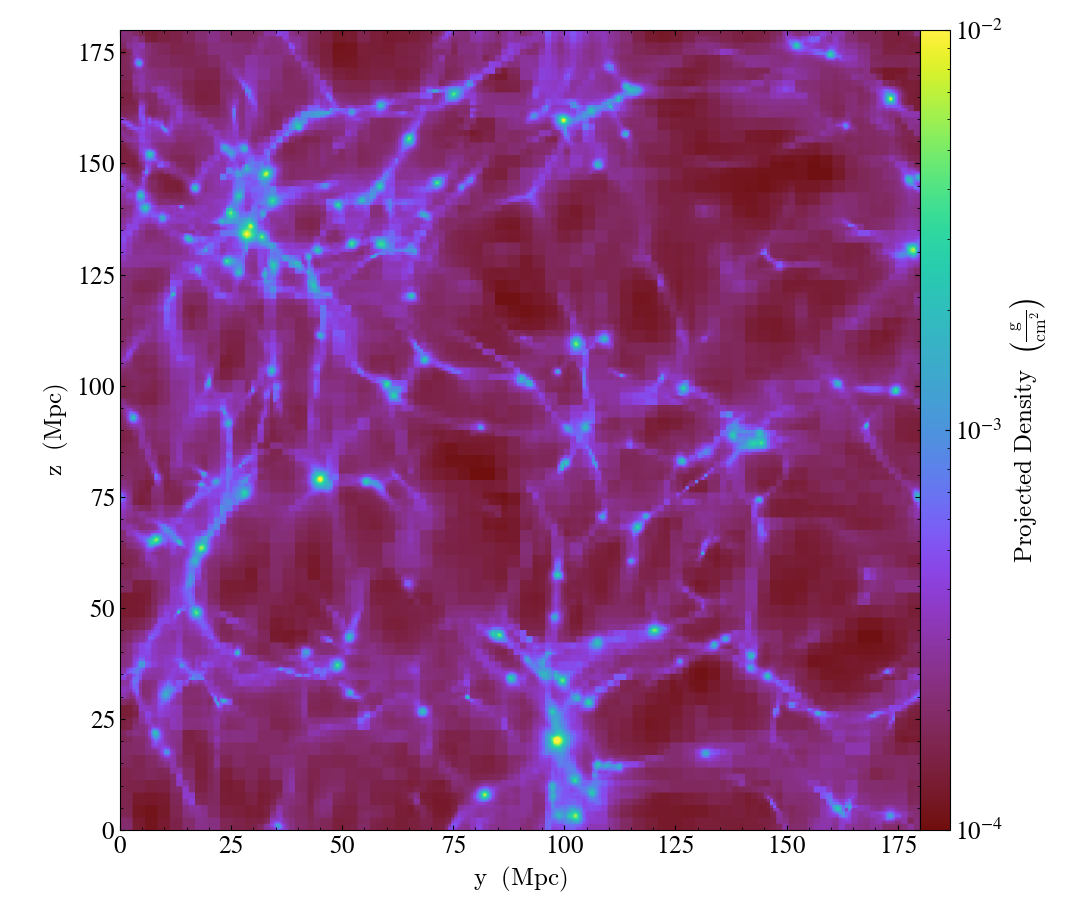

In [3]:
p_whole_domain = yt.ProjectionPlot(ds, 'x', ('gas', 'density'),origin="native" )
p_whole_domain.set_zlim(('gas', 'density'), 1e-4, 1e-2)
p_whole_domain.show()

and say we want to check out the cluster of high density regions in the upper left in a bit more detail:

yt : [INFO     ] 2025-07-02 21:47:37,749 Projection completed
yt : [INFO     ] 2025-07-02 21:47:37,750 xlim = 0.055546 0.277730
yt : [INFO     ] 2025-07-02 21:47:37,750 ylim = 0.638779 0.860963
yt : [INFO     ] 2025-07-02 21:47:37,751 xlim = 0.055546 0.277730
yt : [INFO     ] 2025-07-02 21:47:37,751 ylim = 0.638779 0.860963
yt : [INFO     ] 2025-07-02 21:47:37,752 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



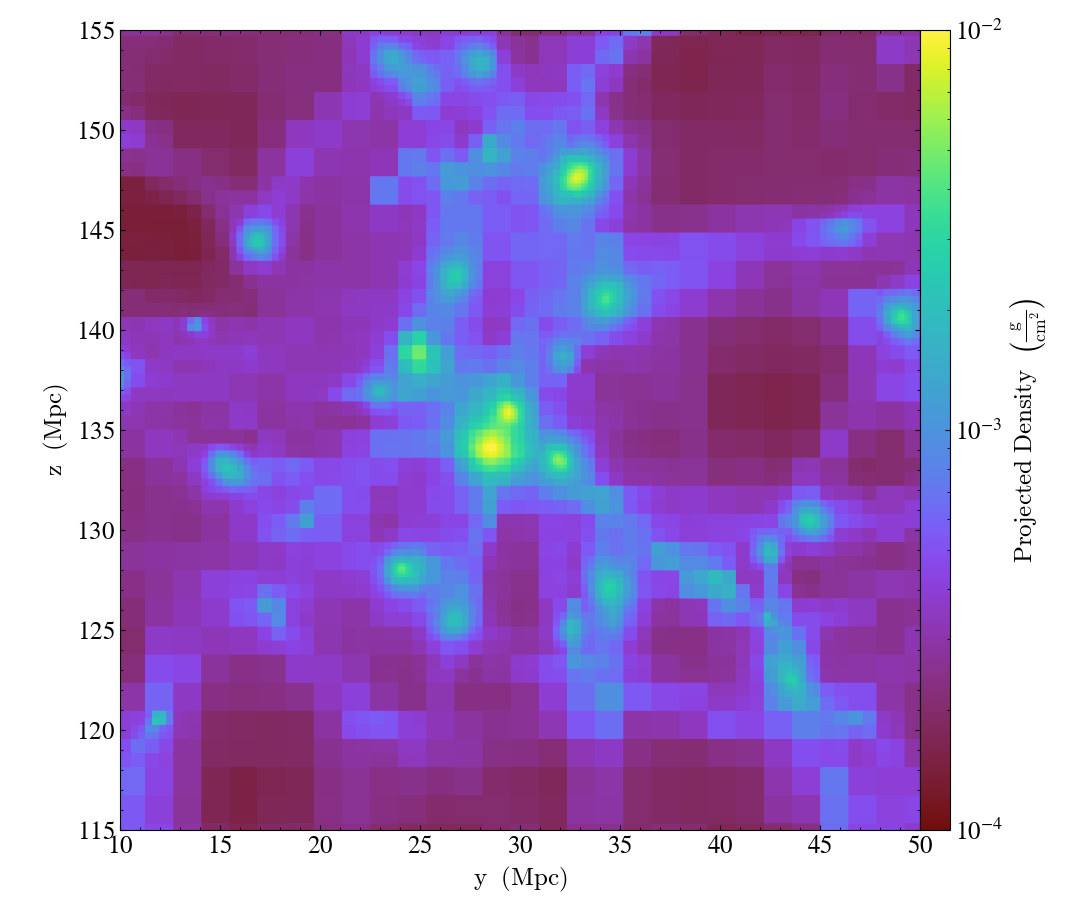

In [4]:
c = ds.arr([100,30,135], 'Mpc')
wid = ds.quan(40, 'Mpc')

p_zoom = yt.ProjectionPlot(ds, 
                       'x', ('gas', 'density'), 
                       center=c,
                       width=wid, 
                       origin='native')
p_zoom.set_zlim(('gas', 'density'), 1e-4, 1e-2)

Now, the goal is to use `p_zoom` as our base image and add `p_whole_domain` within a new matplotlib axes that exists within the `p_zoom` figure. 

To do this, we'll need to access the underlying matplotlib objects stored in the yt plot containers.

First, yt plot containers have dict-like access to the yt plot objects. To check the fields in a plot:


In [5]:
p_zoom.fields

[('gas', 'density')]

and to access the underyling matplotlib figure and axes handles:

In [6]:
mpl_fig = p_zoom[('gas', 'density')].figure
mpl_ax = p_zoom[('gas', 'density')].axes
print(type(mpl_fig), type(mpl_ax))

<class 'matplotlib.figure.Figure'> <class 'matplotlib.axes._axes.Axes'>


having acces to the underlying matplotlib objects opens up the whole matplotlib API!

In our case, we want to use the `figure.add_axes` function to add a new set of child axes, and then we want to re-assign the `p_whole_domain` to (1) use those axes and (2) use the figure for `p_zoom`:


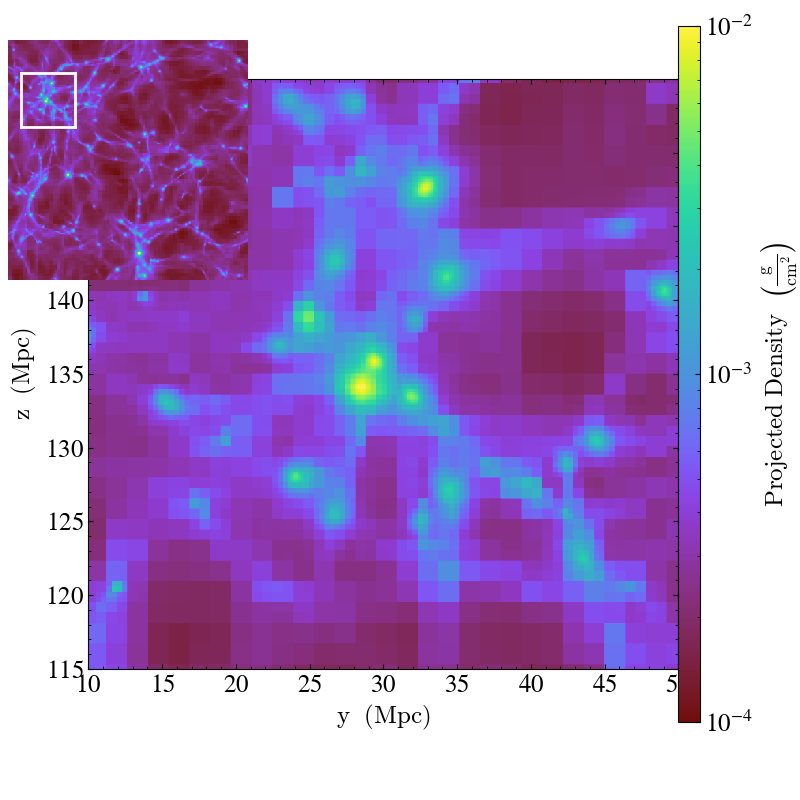

In [7]:
# first, hide the colorbar and axes for `p_whole_domain`:
p_whole_domain.hide_colorbar()
p_whole_domain.hide_axes()

# now, add our new axes
zoom_box_axes = [0.01, 0.65, 0.3, 0.3]
ax2 = p_zoom[('gas', 'density')].figure.add_axes(zoom_box_axes)

# over-ride p_whole_domain axes and figure for ('gas', 'density') to 
# point to the new axes and the figure for p_zoom ('gas', 'density')
p_whole_domain.plots[('gas', 'density')].axes = ax2
p_whole_domain.plots[('gas', 'density')].figure = p_zoom.plots[('gas', 'density')].figure

# add an outline in the inset to indicate the zoom
# using annotate_line to draw 4 lines to show the 
# bounding box of the zoom
pt1 = c - wid/2
pt2 = pt1 + wid * ds.arr([0, 0, 1],'')
p_whole_domain.annotate_line(pt1, pt2)

pt1 = pt2 
pt2 = pt1 + wid * ds.arr([0, 1, 0],'')
p_whole_domain.annotate_line(pt1, pt2)

pt1 = pt2 
pt2 = pt1 + wid * ds.arr([0, 0, -1],'')
p_whole_domain.annotate_line(pt1, pt2)

pt1 = pt2 
pt2 = pt1 + wid * ds.arr([0, -1, 0],'')
p_whole_domain.annotate_line(pt1, pt2)
p_whole_domain.render()

# always reset before the final show/render!!
ax2.set_position(zoom_box_axes)
p_zoom.show()

In [8]:
p_zoom.save('figures/Plotting_02_02_InsetFigures_Enzo_64.png')

yt : [INFO     ] 2025-07-02 21:47:38,352 Saving plot figures/Plotting_02_02_InsetFigures_Enzo_64.png


['figures/Plotting_02_02_InsetFigures_Enzo_64.png']

## And now for some mapping!

### extra dependencies

For this, you'll want some extra dependencies

```
python -m pip install cartopy 
python -m pip install yt_xarray 
python -m pip install netcdf4
python -m pip install scipy
```

cartopy for map projections in yt figures and yt_xarray for streamlining the netcdf loading to get a yt dataset (yt_xarray will also install xarray for you)


In [9]:
# imports for loading the seismic tomography model
# not needed if you are working with a different 
# dataset
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import yt_xarray 
import xarray as xr

First, load the dataset:

In [10]:
vs_file = "IRIS/wUS-SH-2010_percent.nc"
ds_xr = yt_xarray.open_dataset(vs_file)  # an xarray dataset
ds_yt = ds_xr.yt.load_grid()  # a yt dataset

yt_xarray : [INFO ] 2025-07-02 21:47:38,557:  Inferred geometry type is geodetic. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2025-07-02 21:47:38,557:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2025-07-02 21:47:38,557:      stretched grid detected: yt_xarray will interpolate.
yt : [INFO     ] 2025-07-02 21:47:38,587 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-02 21:47:38,587 Parameters: domain_dimensions         = [ 18  92 121]
yt : [INFO     ] 2025-07-02 21:47:38,587 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2025-07-02 21:47:38,587 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2025-07-02 21:47:38,588 Parameters: cosmological_simulation   = 0


Now, let's check how to access underlying matplotlib handles. First, create a SlicePlot for example:

yt : [INFO     ] 2025-07-02 21:47:38,830 xlim = -125.750000 -95.500000
yt : [INFO     ] 2025-07-02 21:47:38,830 ylim = 27.500000 50.500000
yt : [INFO     ] 2025-07-02 21:47:38,830 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2025-07-02 21:47:38,832 xlim = -125.750000 -95.500000
yt : [INFO     ] 2025-07-02 21:47:38,832 ylim = 27.500000 50.500000
yt : [INFO     ] 2025-07-02 21:47:38,833 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



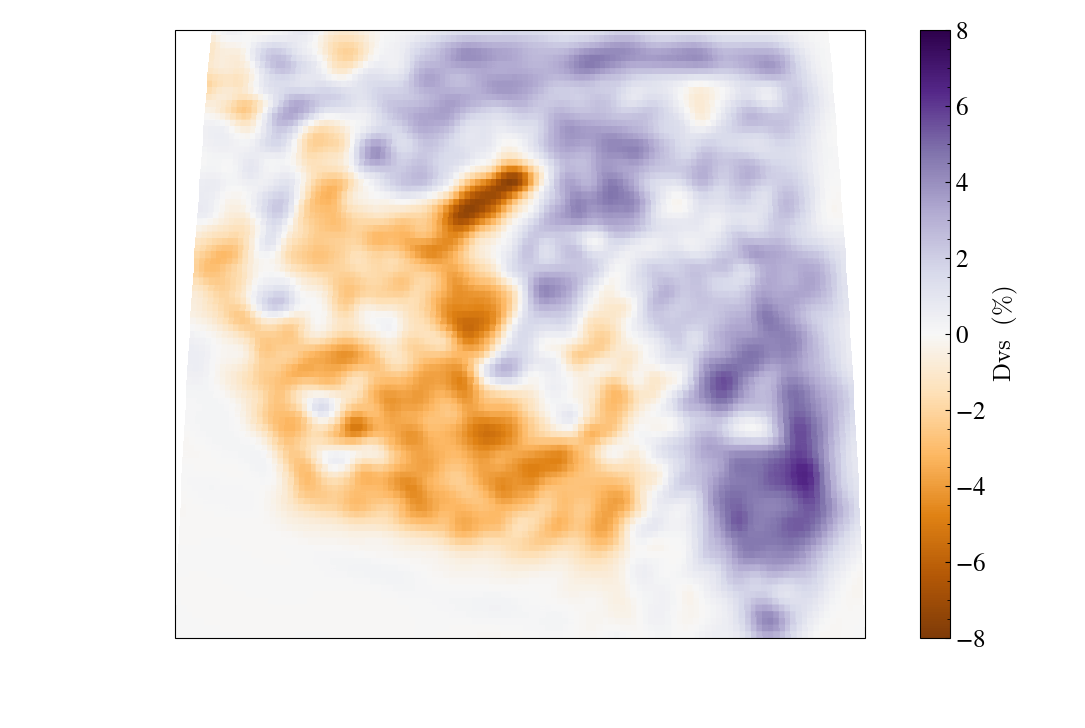

In [11]:
c = ds_yt.domain_center.copy()
c[0]=150
p = yt.SlicePlot(ds_yt, "depth", 'dvs',center=c)
p.set_mpl_projection(('Robinson', () , {'central_longitude':float(c[2].value), 'globe':None} ))
p.set_log('dvs',False)
p.set_zlim('dvs',-8, 8)
p.set_cmap('dvs','PuOr')
p.show()

Now, the `fields` attributes will be a list of fields that are in the plot container (we have just one in this case):

In [12]:
p.fields

['dvs']

You can get the yt plot container with dict-like access for the field, which itself contains references to underlying matplotlib objects:

In [13]:
type(p['dvs'].figure)

matplotlib.figure.Figure

In [14]:
type(p['dvs'].axes)

cartopy.mpl.geoaxes.GeoAxes

For geographic plots in yt, using cartopy functionality typically requires accessing these attributes. For example, to to add reference shapefile outlines from NaturalEarth:


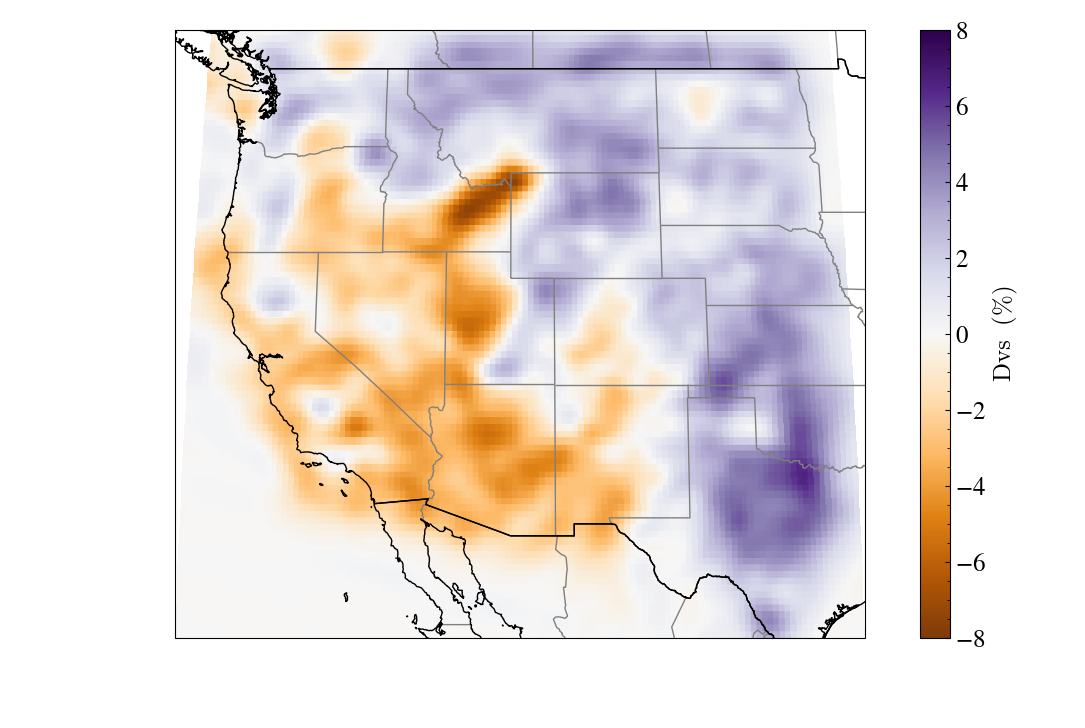

In [15]:

p.plots["dvs"].axes.add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_1_states_provinces_lines', '10m',
        edgecolor='gray', facecolor='none'))
p.plots["dvs"].axes.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_countries', '10m',
            edgecolor='black', facecolor='none')) 

p.show()

and then adjust extents (to zoom in on the yellowstone hotspot track):


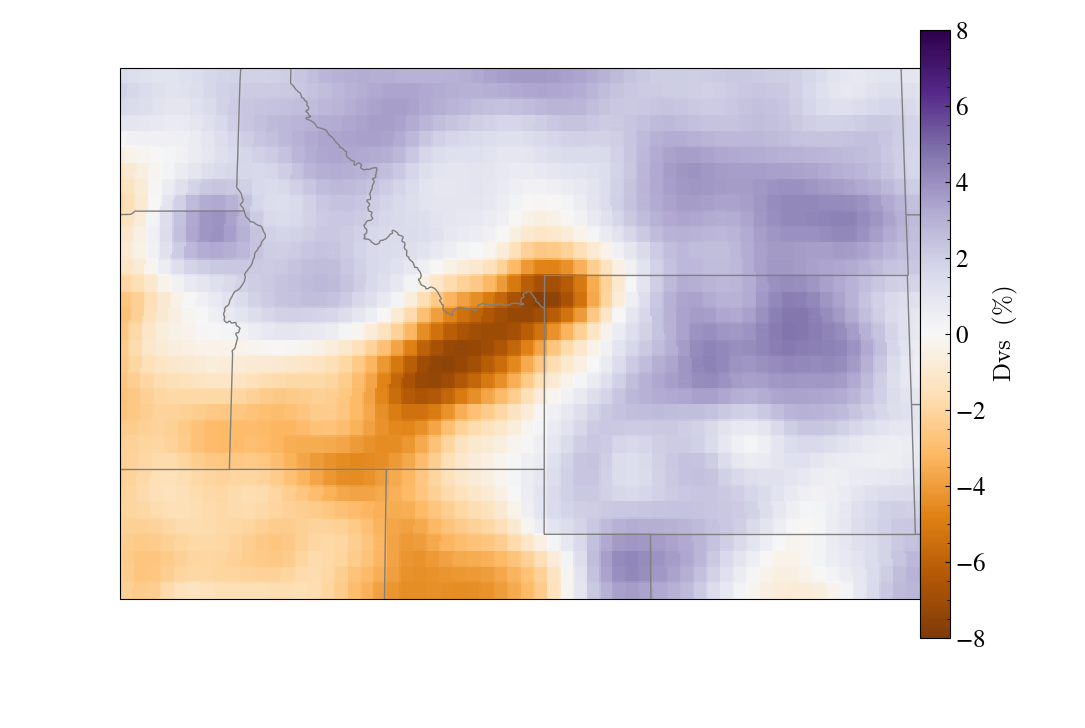

In [16]:
p.plots["dvs"].axes.set_extent((-119, -104, 40, 48))
p.show()

Now we're ready to create our full figure

yt : [INFO     ] 2025-07-02 21:47:43,405 xlim = -125.750000 -95.500000
yt : [INFO     ] 2025-07-02 21:47:43,406 ylim = 27.500000 50.500000
yt : [INFO     ] 2025-07-02 21:47:43,406 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2025-07-02 21:47:43,407 xlim = -125.750000 -95.500000
yt : [INFO     ] 2025-07-02 21:47:43,407 ylim = 27.500000 50.500000
yt : [INFO     ] 2025-07-02 21:47:43,408 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [INFO     ] 2025-07-02 21:47:45,605 xlim = -125.750000 -95.500000
yt : [INFO     ] 2025-07-02 21:47:45,605 ylim = 27.500000 50.500000
yt : [INFO     ] 2025-07-02 21:47:45,606 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2025-07-02 21:47:45,607 xlim = -125.750000 -95.500000
yt : [INFO     ] 2025-07-02 21:47:45,607 ylim = 27.500000 50.500000
yt : [INFO     ] 2025-07-02 21:47:45,608 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



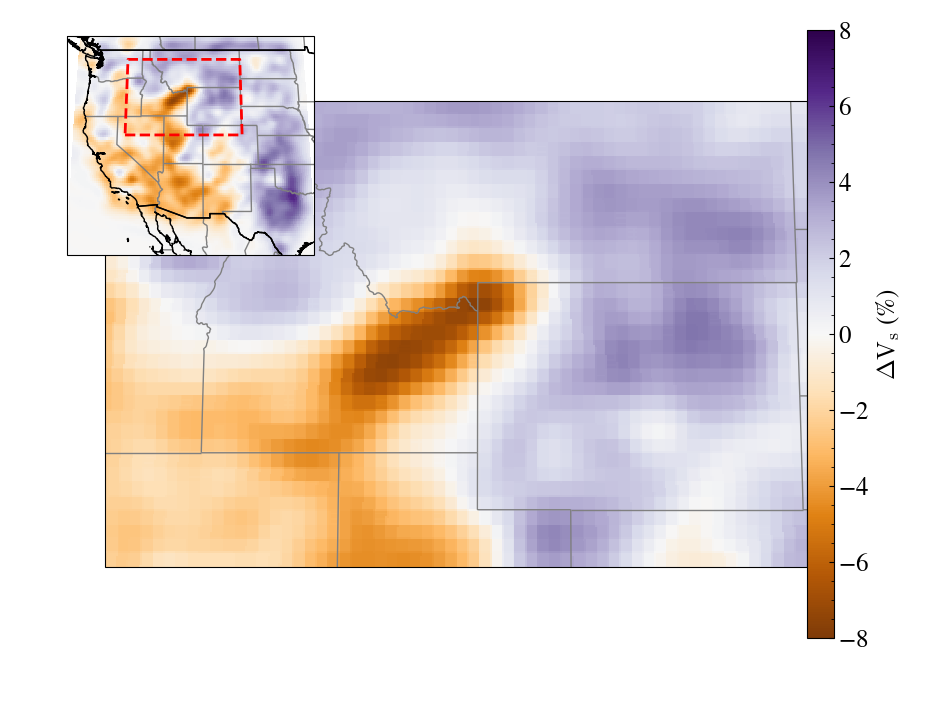

In [17]:
c = ds_yt.domain_center.copy()
c[0] = 150.

zoom_extents = (-119, -104, 40, 48)

def get_slice():
    # get the base slice for both plots
    p = yt.SlicePlot(ds_yt, "depth", 'dvs',center=c)
    p.set_mpl_projection(('Robinson', () , {'central_longitude':float(c[2].value), 'globe':None} ))
    p.set_log('dvs',False)
    p.set_zlim('dvs',-8, 8)
    p.set_cmap('dvs','PuOr')
    return p


def add_features(carto_ax):
    # add NaturalEarthFeature objects to a cartopy axis
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_1_states_provinces_lines', '10m',
        edgecolor='gray', facecolor='none'))
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_countries', '10m',
            edgecolor='black', facecolor='none'))    
     
# initialize our slice plot to the zoomed-in view
p = get_slice()
p.set_colorbar_label('dvs',"$\Delta\mathrm{V_s}$ (%)")
p.render()

# set the cartopy axes extents via set_extent on the 
# underlying cartopy GeoAxes
p.plots["dvs"].axes.set_extent(zoom_extents)

# add in our features
add_features(p.plots["dvs"].axes)


# add a small child axis with the same projection
# (use add_axes as for the astro example but 
# pass it the projection keyword)
locator_box = [0.05, 0.65, 0.3, 0.3]
proj = p.plots["dvs"].axes.projection # exctract projection used in first plot
ax2 = p.plots["dvs"].figure.add_axes(locator_box, projection=proj)

# get a new slice, covering the whole domain and adjust the axes and 
# figure references the child axis and existing figure
p2 = get_slice()
p2.plots["dvs"].axes = ax2
p2.plots["dvs"].figure = p.plots["dvs"].figure

# hide colorbar for inset figure
p2.hide_colorbar()

# makes ure p2 has re-rendered before adding annotations on top 
p2.render()

# add our features 
add_features(ax2)

# manually plot a box to indicate zoom extent
xlocs = [zoom_extents[0], zoom_extents[1], zoom_extents[1], 
             zoom_extents[0], zoom_extents[0]]
ylocs = [zoom_extents[2], zoom_extents[2], zoom_extents[3],
         zoom_extents[3], zoom_extents[2] ]
ax2.plot(xlocs, ylocs, transform=ccrs.PlateCarree(), color='r', linestyle='--', linewidth=2)



# the child axes position gets reset somewhere, so set it again here
ax2.set_position(locator_box) 

p.show()

In [18]:
p.save('figures/Plotting_02_01_InsetFigures_map.png')

yt : [INFO     ] 2025-07-02 21:47:48,018 Saving plot figures/Plotting_02_01_InsetFigures_map.png


['figures/Plotting_02_01_InsetFigures_map.png']